<a href="https://colab.research.google.com/github/itzThillaiC/Astronomical-image-denoiser/blob/main/SRGAN_model200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the required packages

In [23]:
import os
import random
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [24]:
IMAGES_PATH = '/content/drive/My Drive/Galaxy10/'
IMAGES = os.listdir(IMAGES_PATH)
random.shuffle(IMAGES)

In [25]:
len(IMAGES)

503

Assigning the device as cuda if GPU is available else cpu

In [26]:
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

Defining the generator architecture as given the reference paper

In [27]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

Assigning the Generator to cuda(if available) and printing the summary of the Generator with a dummy input

In [28]:
gen = Generator().to(cuda)

#Uncomment below mentioned three lines if you have more than one gpu and want to use all of them
#ngpu=2
# if (cuda.type == 'cuda') and (ngpu > 1):
#     gen = n.DataParallel(gen, list(range(ngpu)))
summary(gen,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,552
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
            PReLU-10           [-1, 64, 64, 64]               1
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

Defining the Discriminator network as given in the reference paper expect that a dropout in the last layer

In [29]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8),)
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10

Assigning the discriminator to the gpu(if available) and printing the summary of the network with a dummy value

In [30]:
disc = Discriminator().to(cuda)
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
            Conv2d-2         [-1, 64, 128, 128]          36,864
       BatchNorm2d-3         [-1, 64, 128, 128]             128
            Conv2d-4        [-1, 128, 128, 128]          73,728
       BatchNorm2d-5        [-1, 128, 128, 128]             256
            Conv2d-6          [-1, 128, 64, 64]         147,456
       BatchNorm2d-7          [-1, 128, 64, 64]             256
            Conv2d-8          [-1, 256, 64, 64]         294,912
       BatchNorm2d-9          [-1, 256, 64, 64]             512
           Conv2d-10          [-1, 256, 32, 32]         589,824
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 512, 32, 32]       1,179,648
      BatchNorm2d-13          [-1, 512, 32, 32]           1,024
           Conv2d-14          [-1, 512,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [31]:
disc = Discriminator().to(cuda).float()
gen = Generator().to(cuda).float()

Downloading the pretrained vgg19 model from model module of torchvision library

In [32]:
vgg = models.vgg19(pretrained=True).to(cuda)

Defining the losses to be used in training

In [33]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

Defining the adam optimizers for generator and discriminator

In [34]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

Loading the images after based on resizing as numpy array

In [35]:
def loadImages(IMAGES,path,resize=False):
    images=[]
    for image in (IMAGES):
#         print(image)
        if resize:
            img = cv2.resize(cv2.imread(os.path.join(path,image)),(256,256)) 
        else:
            img = cv2.imread(os.path.join(path,image))
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
#         print(img.shape)
        img = np.moveaxis(img, 2, 0)
#         print(img.shape)
        images.append(img)
    return np.array(images)

Converting the high resolution images into low resolution by applying gaussian blur, resizing in to 64*64 and loading it as numpy array

In [36]:
def loadLRImages(IMAGES,path):
    images=[]
    for image in (IMAGES):
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(path,image)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
        img = np.moveaxis(img, 2, 0)
        images.append(img)
    return np.array(images)

Loading the generator model from the given checkpoint

In [37]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

Given low resolution images and checkpoint, Generating the high resolution images out of it 

In [38]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(hr_path,img)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
#     imagearray = (imagedir)/255
    # imagearrayPT = np.reshape(imagearray,(len(imagelist),imagearray.shape[3],imagearray.shape[1],imagearray.shape[2]))
    imagearrayPT = np.moveaxis(imagearray,3,1)
    # print(imagearrayPT.shape)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    # print(out_tensor.shape)
    # out = np.reshape(out_tensor,[out_tensor.shape[0],out_tensor.shape[2],out_tensor.shape[3],out_tensor.shape[1]])
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    # print(out.shape)
    out = np.clip(out,0,1)
    
    return out

Display utility of displaying images using matplotlib

In [39]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array * 255).astype('uint8'))
    plt.savefig(os.path.join(base_path,"out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [40]:
#change the batch-size based on your system memory

epochs=250
batch_size=5

In [41]:
import os 
base_path = os.getcwd()

#lr_path = os.path.join(base_path,"trainImages")
hr_path =IMAGES_PATH
#valid_path = os.path.join(base_path,"SR_valid")
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)

    
#LR_images_list = os.listdir(lr_path)
HR_images_list = IMAGES
batch_count = len(HR_images_list)//batch_size
batch_count

100

Starting of training and defining losses

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 60/60 [00:34<00:00,  1.74it/s]


Epoch ::::  1  d1_loss ::: 0.5272274304873463  d2_loss :::0.40757280937209306
genLoss ::: 13.611103693174604  vggLoss ::: 0.05200175273542603  MeanLoss  ::: 0.0036493385404658815


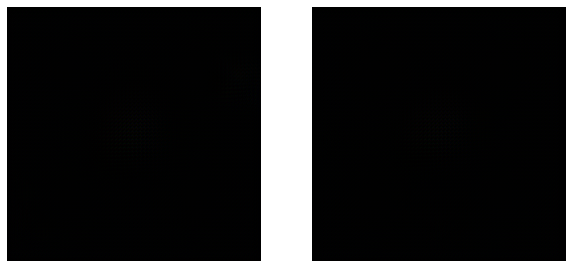

100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


Epoch ::::  2  d1_loss ::: 0.6060541425263712  d2_loss :::0.3733572907745838
genLoss ::: 24.152702923615774  vggLoss ::: 0.029620547530551752  MeanLoss  ::: 0.0015360199729911983


100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


Epoch ::::  3  d1_loss ::: 0.23603283581371023  d2_loss :::0.20052501500801959
genLoss ::: 21.580174048741657  vggLoss ::: 0.027892668421069782  MeanLoss  ::: 0.0013278525283870598


100%|██████████| 60/60 [00:35<00:00,  1.68it/s]


Epoch ::::  4  d1_loss ::: 0.22415971834998344  d2_loss :::0.18058644221697664
genLoss ::: 23.36699114640554  vggLoss ::: 0.02514319351563851  MeanLoss  ::: 0.001143673745294412


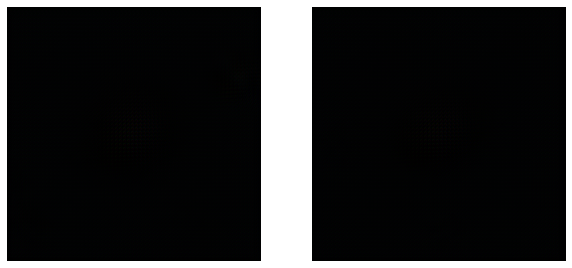

100%|██████████| 60/60 [00:36<00:00,  1.67it/s]


Epoch ::::  5  d1_loss ::: 0.5669488481551344  d2_loss :::0.27055098953490625
genLoss ::: 24.955847589174905  vggLoss ::: 0.022247457209353647  MeanLoss  ::: 0.001014400918696386


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


Epoch ::::  6  d1_loss ::: 0.3438666408260663  d2_loss :::0.5157590882245343
genLoss ::: 33.115967106819156  vggLoss ::: 0.020775181225811443  MeanLoss  ::: 0.0009468102822817551


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  7  d1_loss ::: 0.18715415520899129  d2_loss :::0.21953234072452343
genLoss ::: 31.4817777077357  vggLoss ::: 0.019999761149908105  MeanLoss  ::: 0.0008998291746441585


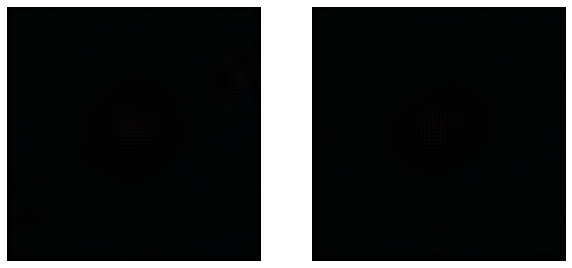

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  8  d1_loss ::: 0.270168611368477  d2_loss :::0.34546348110986097
genLoss ::: 35.67712749640147  vggLoss ::: 0.01953014450458189  MeanLoss  ::: 0.000860750190622639


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  9  d1_loss ::: 0.22010448417980488  d2_loss :::0.20815108047390443
genLoss ::: 31.642157888412477  vggLoss ::: 0.019211010945339998  MeanLoss  ::: 0.0008209693565731868


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  10  d1_loss ::: 0.20849145308148773  d2_loss :::0.23125269545734373
genLoss ::: 37.69744551976522  vggLoss ::: 0.018962661161397894  MeanLoss  ::: 0.0007840231570298784


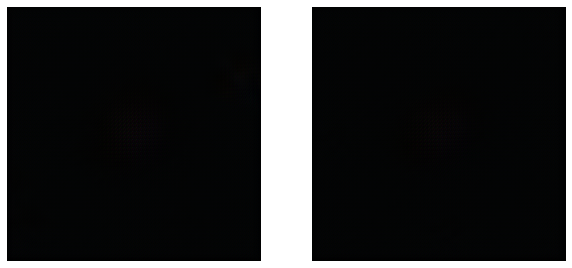

100%|██████████| 60/60 [00:36<00:00,  1.67it/s]


Epoch ::::  11  d1_loss ::: 0.6013241389882751  d2_loss :::0.24886625086672867
genLoss ::: 54.9306293964386  vggLoss ::: 0.018758607485021155  MeanLoss  ::: 0.0007516525462657834


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  12  d1_loss ::: 0.37905814937845217  d2_loss :::0.3287293499339084
genLoss ::: 25.930610513687135  vggLoss ::: 0.018576541480918727  MeanLoss  ::: 0.0007241806010521638


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  13  d1_loss ::: 0.26213458000370876  d2_loss :::0.3104569014593025
genLoss ::: 38.09722896814346  vggLoss ::: 0.018424728233367205  MeanLoss  ::: 0.0006983412274469932


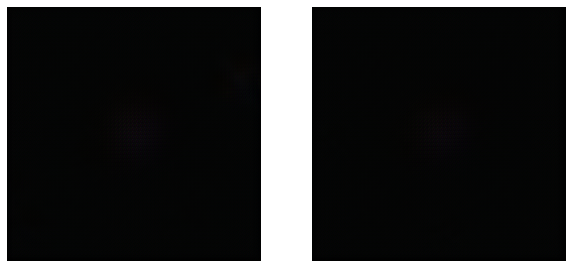

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  14  d1_loss ::: 0.20801421455726787  d2_loss :::0.24555968507503553
genLoss ::: 33.188734451929726  vggLoss ::: 0.01829369803890586  MeanLoss  ::: 0.0006753847032086924


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  15  d1_loss ::: 0.19705893748878883  d2_loss :::0.20838781965275643
genLoss ::: 40.72835919062297  vggLoss ::: 0.01817628601565957  MeanLoss  ::: 0.0006535953514685388


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  16  d1_loss ::: 0.19177117060230559  d2_loss :::0.23078390376521038
genLoss ::: 45.82896606127421  vggLoss ::: 0.01805700344654421  MeanLoss  ::: 0.0006336141717232143


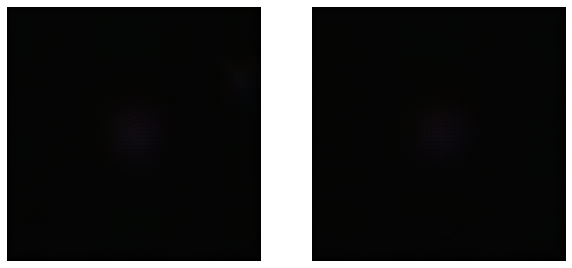

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  17  d1_loss ::: 0.2301092895173013  d2_loss :::0.263038436571757
genLoss ::: 32.27661291758219  vggLoss ::: 0.017954794705534974  MeanLoss  ::: 0.0006075989721769777


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  18  d1_loss ::: 0.2302019993433108  d2_loss :::0.24672349179797426
genLoss ::: 36.69949018160502  vggLoss ::: 0.017863437191893657  MeanLoss  ::: 0.0005827321559384776


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  19  d1_loss ::: 0.2055614988261368  d2_loss :::0.29038730395479223
genLoss ::: 36.28653701146444  vggLoss ::: 0.01777971014380455  MeanLoss  ::: 0.0005603558631264605


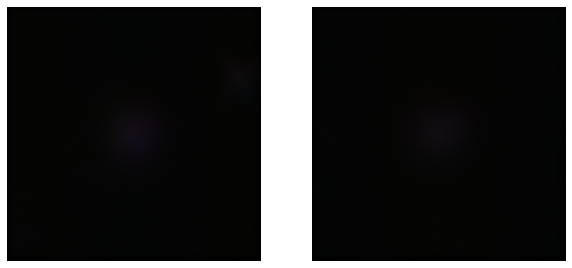

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  20  d1_loss ::: 0.2487069315219344  d2_loss :::0.21804400548338895
genLoss ::: 32.15465514659881  vggLoss ::: 0.01770216830385228  MeanLoss  ::: 0.000543635462236125


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  21  d1_loss ::: 0.19271895925019247  d2_loss :::0.18142423546121847
genLoss ::: 41.52459894021352  vggLoss ::: 0.01763146819236378  MeanLoss  ::: 0.0005377029893376555


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  22  d1_loss ::: 0.20350473597776422  d2_loss :::0.21487562706073124
genLoss ::: 38.73335124651591  vggLoss ::: 0.01755394561526676  MeanLoss  ::: 0.0005288790018918613


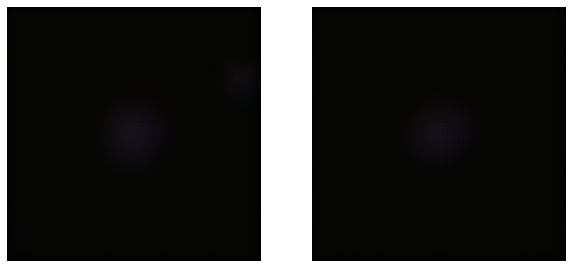

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  23  d1_loss ::: 0.22186077882846197  d2_loss :::0.20794415781895356
genLoss ::: 39.02536764144897  vggLoss ::: 0.01748149801666538  MeanLoss  ::: 0.0005249226184484238


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  24  d1_loss ::: 0.21949879303575603  d2_loss :::0.20332317675153413
genLoss ::: 39.38228837649027  vggLoss ::: 0.017424816684797406  MeanLoss  ::: 0.0005265302053885535


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  25  d1_loss ::: 0.21025667930894248  d2_loss :::0.20101268490155538
genLoss ::: 39.77453485329946  vggLoss ::: 0.017367996694520115  MeanLoss  ::: 0.0005213401115421826


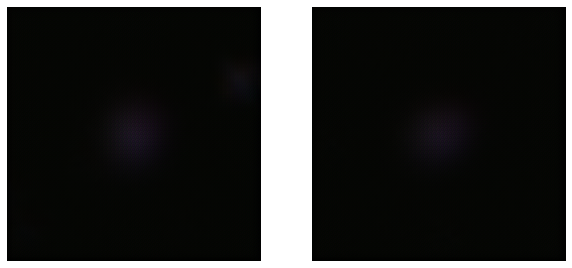

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  26  d1_loss ::: 0.2079841572543095  d2_loss :::0.18946023136377335
genLoss ::: 39.626321442921956  vggLoss ::: 0.01729387474867205  MeanLoss  ::: 0.0005072648064621414


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  27  d1_loss ::: 0.19870478623415705  d2_loss :::0.20794415861368284
genLoss ::: 40.99524777730306  vggLoss ::: 0.01722738058306277  MeanLoss  ::: 0.0004956106451572851


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  28  d1_loss ::: 0.23107982966413504  d2_loss :::0.22180710087219874
genLoss ::: 34.15615301132202  vggLoss ::: 0.017165471302966275  MeanLoss  ::: 0.00048757613015671574


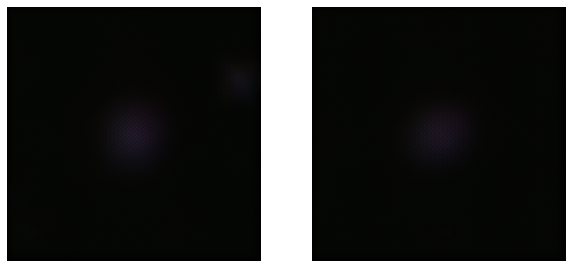

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  29  d1_loss ::: 0.2125908703347238  d2_loss :::0.22873857195178668
genLoss ::: 34.61317247549693  vggLoss ::: 0.01710220893534521  MeanLoss  ::: 0.00047979243245208634


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  30  d1_loss ::: 0.17097860351204872  d2_loss :::0.20563366845250167
genLoss ::: 38.721145725250246  vggLoss ::: 0.01704288460314274  MeanLoss  ::: 0.0004694145250444611


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  31  d1_loss ::: 0.21718784575661704  d2_loss :::0.203323177893958
genLoss ::: 35.4661009311676  vggLoss ::: 0.016985381580889226  MeanLoss  ::: 0.00046047553454021305


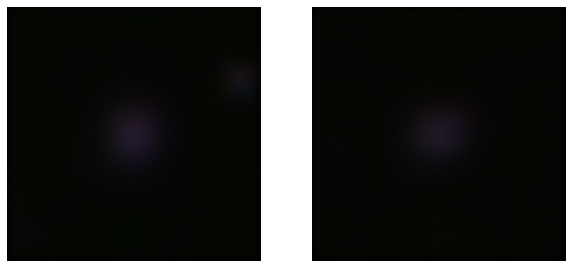

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  32  d1_loss ::: 0.19641704184844191  d2_loss :::0.2148756315310796
genLoss ::: 35.46828827460607  vggLoss ::: 0.016931226088975865  MeanLoss  ::: 0.00045214115186051156


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  33  d1_loss ::: 0.21028082013179852  d2_loss :::0.16173434630036354
genLoss ::: 33.74303544362386  vggLoss ::: 0.01687700441107154  MeanLoss  ::: 0.0004444793373598562


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  34  d1_loss ::: 0.20335305552340366  d2_loss :::0.20332317401965458
genLoss ::: 33.52919688224792  vggLoss ::: 0.016828770516440272  MeanLoss  ::: 0.00043883779871976


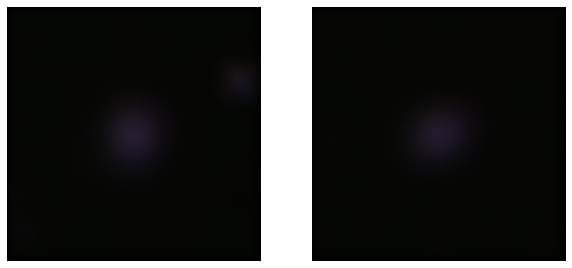

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  35  d1_loss ::: 0.1964189967333179  d2_loss :::0.2079441577196121
genLoss ::: 32.896885299682616  vggLoss ::: 0.01677782468808194  MeanLoss  ::: 0.0004332372748952669


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  36  d1_loss ::: 0.20334628790618048  d2_loss :::0.1894602338473002
genLoss ::: 33.32096250057221  vggLoss ::: 0.01672708187252283  MeanLoss  ::: 0.00042993848571010553


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  37  d1_loss ::: 0.20564533352856368  d2_loss :::0.19177072862784214
genLoss ::: 32.57260538736979  vggLoss ::: 0.01668519728506605  MeanLoss  ::: 0.0004273634018318262


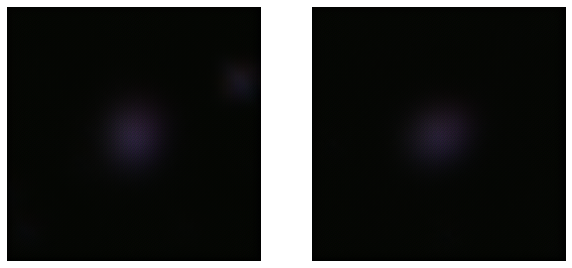

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  38  d1_loss ::: 0.19871151636810586  d2_loss :::0.21256514241298038
genLoss ::: 33.23039844830831  vggLoss ::: 0.01664286319476863  MeanLoss  ::: 0.00041977483003089827


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  39  d1_loss ::: 0.2080485796045347  d2_loss :::0.17097631608446445
genLoss ::: 31.47066570520401  vggLoss ::: 0.016600807119781773  MeanLoss  ::: 0.00041193211800418796


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  40  d1_loss ::: 0.20341055797285415  d2_loss :::0.22180724019893316
genLoss ::: 35.10053853988647  vggLoss ::: 0.01655889516696334  MeanLoss  ::: 0.00040604133973829446


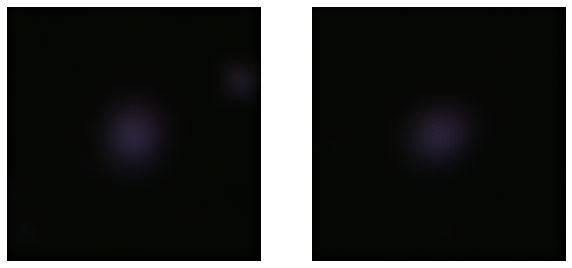

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  41  d1_loss ::: 0.2033233580490024  d2_loss :::0.20794448023041803
genLoss ::: 35.21655286947886  vggLoss ::: 0.016517096074918906  MeanLoss  ::: 0.0003998779255198315


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  42  d1_loss ::: 0.21718859607974797  d2_loss :::0.21025519714509452
genLoss ::: 32.32050604025523  vggLoss ::: 0.016470038223390777  MeanLoss  ::: 0.00039337069198760826


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  43  d1_loss ::: 0.1825307121136076  d2_loss :::0.1940817134236323
genLoss ::: 34.15408891042073  vggLoss ::: 0.016429743946840367  MeanLoss  ::: 0.000388790167926345


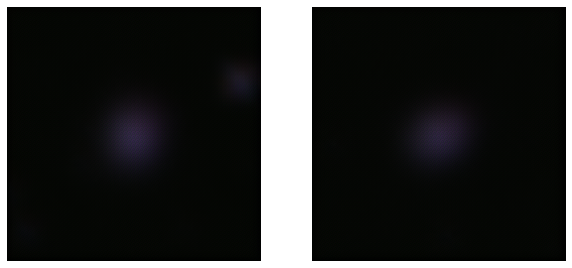

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  44  d1_loss ::: 0.2319385039309971  d2_loss :::0.22180757467948803
genLoss ::: 28.41919838587443  vggLoss ::: 0.016396008742352326  MeanLoss  ::: 0.0003863236731073509


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  45  d1_loss ::: 0.18550112233063012  d2_loss :::0.18868571277293716
genLoss ::: 23.13982278505961  vggLoss ::: 0.01635309962245325  MeanLoss  ::: 0.00038149697041565863


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  46  d1_loss ::: 0.21718733787538724  d2_loss :::0.21052101862248399
genLoss ::: 22.802811551094056  vggLoss ::: 0.016319865609208742  MeanLoss  ::: 0.00037837119549900914


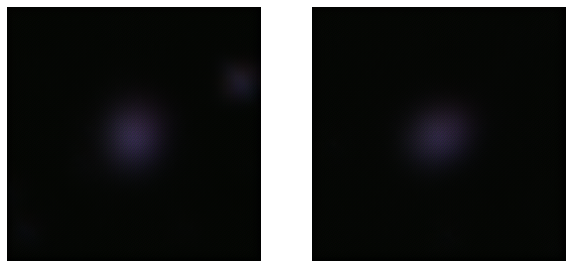

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  47  d1_loss ::: 0.24725652345549254  d2_loss :::0.24491227939724994
genLoss ::: 20.74041746457418  vggLoss ::: 0.016275036567822098  MeanLoss  ::: 0.0003708832906947161


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  48  d1_loss ::: 0.3443852856755259  d2_loss :::0.2332837482293447
genLoss ::: 23.26393735408783  vggLoss ::: 0.016237626504153013  MeanLoss  ::: 0.00036597306995342176


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  49  d1_loss ::: 0.25290966416631516  d2_loss :::0.2973893322479037
genLoss ::: 26.259084204832714  vggLoss ::: 0.016196888064344724  MeanLoss  ::: 0.0003599784380639903


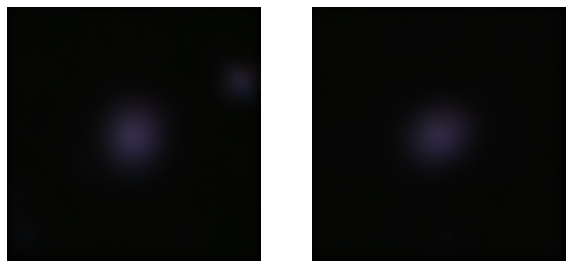

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  50  d1_loss ::: 0.21234730315239478  d2_loss :::0.22719767674969565
genLoss ::: 37.86265114148458  vggLoss ::: 0.01615770684244732  MeanLoss  ::: 0.0003549097088883476


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  51  d1_loss ::: 0.2312671350936095  d2_loss :::0.30521244016929155
genLoss ::: 37.06661136945089  vggLoss ::: 0.016118535896142323  MeanLoss  ::: 0.00034999060759825323


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  52  d1_loss ::: 0.2516171862185189  d2_loss :::0.3357065390835487
genLoss ::: 35.00192515850067  vggLoss ::: 0.016083290505533417  MeanLoss  ::: 0.00034573600545021084


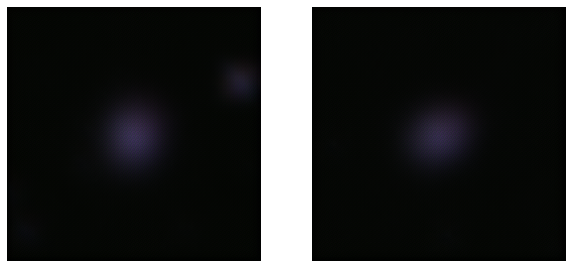

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  53  d1_loss ::: 0.20601011529588237  d2_loss :::0.19697448652921923
genLoss ::: 20.388478978474936  vggLoss ::: 0.016051280902077754  MeanLoss  ::: 0.00034259137294914883


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  54  d1_loss ::: 0.5621667070190927  d2_loss :::0.1918214957416059
genLoss ::: 19.296171895662944  vggLoss ::: 0.016017810829604667  MeanLoss  ::: 0.0003387842254596762


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  55  d1_loss ::: 0.23536844973074048  d2_loss :::0.23248964197393132
genLoss ::: 17.067319869995117  vggLoss ::: 0.01598664092210432  MeanLoss  ::: 0.00033523648550423484


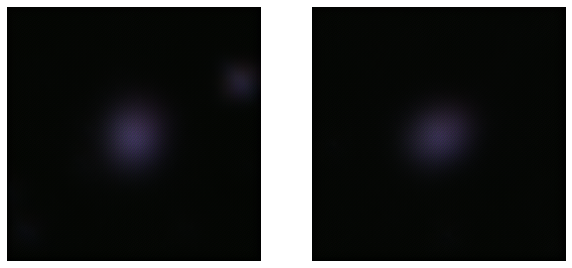

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  56  d1_loss ::: 0.21095211254491553  d2_loss :::0.24373554359278085
genLoss ::: 13.571523304780325  vggLoss ::: 0.01595865705360969  MeanLoss  ::: 0.00033271320620163655


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  57  d1_loss ::: 0.23565191157288368  d2_loss :::0.21137493243762448
genLoss ::: 15.417949457963308  vggLoss ::: 0.01593155744485557  MeanLoss  ::: 0.0003307992495441188


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  58  d1_loss ::: 0.21489778694425207  d2_loss :::0.2118383288462065
genLoss ::: 24.10768694082896  vggLoss ::: 0.015896486149479947  MeanLoss  ::: 0.0003274118959476861


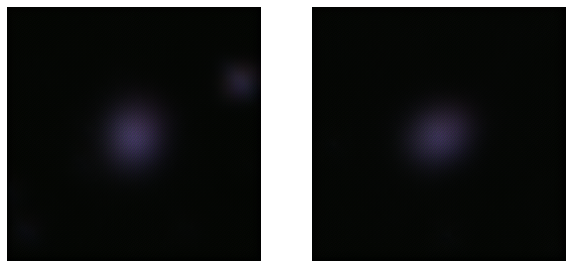

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  59  d1_loss ::: 0.22645935365035624  d2_loss :::0.19870219230651856
genLoss ::: 17.80813000202179  vggLoss ::: 0.015864921500906348  MeanLoss  ::: 0.0003239752065079908


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  60  d1_loss ::: 0.15250723458463133  d2_loss :::0.2033231735229492
genLoss ::: 20.31665719350179  vggLoss ::: 0.01583355516195297  MeanLoss  ::: 0.00031965954476618206


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  61  d1_loss ::: 0.22643357332694  d2_loss :::0.1871497392654419
genLoss ::: 18.17754830121994  vggLoss ::: 0.015813651339461405  MeanLoss  ::: 0.0003173257236388357


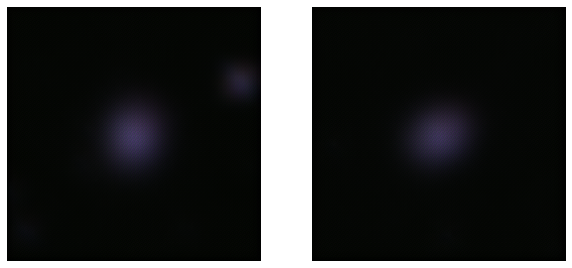

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  62  d1_loss ::: 0.18948650833456473  d2_loss :::0.21949660778045654
genLoss ::: 19.241066932678223  vggLoss ::: 0.015787753090262414  MeanLoss  ::: 0.0003143492511298973


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  63  d1_loss ::: 0.2287470340232056  d2_loss :::0.21256513595581056
genLoss ::: 17.564434067408243  vggLoss ::: 0.015761058731004595  MeanLoss  ::: 0.000310876474880691


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  64  d1_loss ::: 0.2033948000367248  d2_loss :::0.23567004203796388
genLoss ::: 20.316886500517526  vggLoss ::: 0.015735587710514663  MeanLoss  ::: 0.00030782125977566464


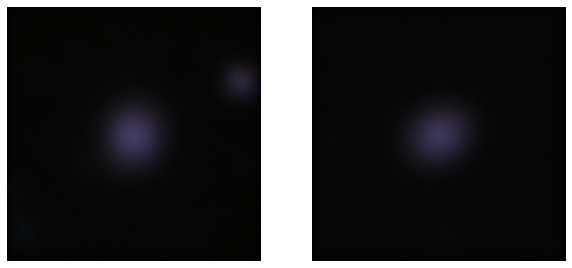

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  65  d1_loss ::: 0.2449156332015992  d2_loss :::0.23335955142974854
genLoss ::: 18.911060786247255  vggLoss ::: 0.015708658378571272  MeanLoss  ::: 0.00030315761371942546


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  66  d1_loss ::: 0.19871753479043644  d2_loss :::0.21256513595581056
genLoss ::: 21.551966905593872  vggLoss ::: 0.015687401049459974  MeanLoss  ::: 0.00030213724506514457


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  67  d1_loss ::: 0.207944465186823  d2_loss :::0.2033231735229492
genLoss ::: 20.88366768360138  vggLoss ::: 0.0156637335040917  MeanLoss  ::: 0.00029727097498835067


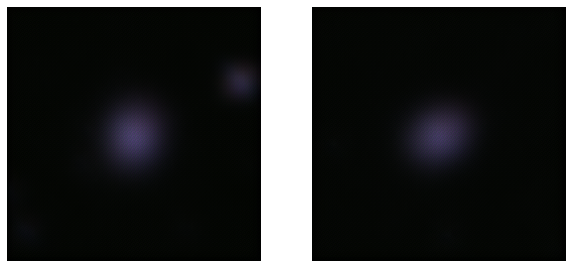

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  68  d1_loss ::: 0.1917817633290758  d2_loss :::0.2310490608215332
genLoss ::: 21.260362402598062  vggLoss ::: 0.015641395902882018  MeanLoss  ::: 0.0002963663927706269


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  69  d1_loss ::: 0.2010157293692829  d2_loss :::0.25646445751190183
genLoss ::: 20.281391684214274  vggLoss ::: 0.015618765307590366  MeanLoss  ::: 0.00029347592014043283


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  70  d1_loss ::: 0.20795915772521692  d2_loss :::0.18252875804901122
genLoss ::: 20.188812478383383  vggLoss ::: 0.015592853274817268  MeanLoss  ::: 0.00029254323914453076


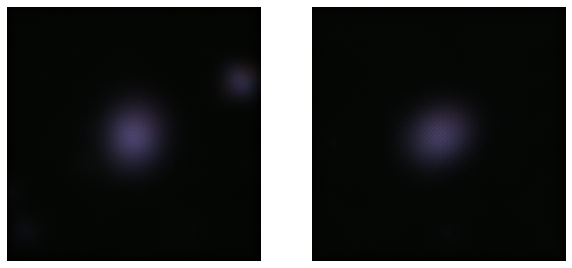

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  71  d1_loss ::: 0.23105686025923286  d2_loss :::0.20563366413116455
genLoss ::: 18.925874702135722  vggLoss ::: 0.015568228717893363  MeanLoss  ::: 0.0002898256136783554


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  72  d1_loss ::: 0.24491440549563126  d2_loss :::0.21487562656402587
genLoss ::: 18.615307148297628  vggLoss ::: 0.015547839784994721  MeanLoss  ::: 0.000288130168094843


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  73  d1_loss ::: 0.19891672321582005  d2_loss :::0.22180919845927222
genLoss ::: 26.287899295488995  vggLoss ::: 0.015527063856522243  MeanLoss  ::: 0.0002860302893774739


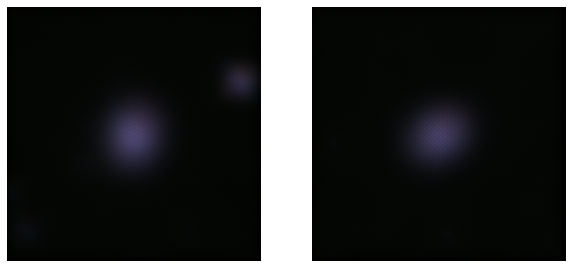

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  74  d1_loss ::: 0.19870219230651856  d2_loss :::0.21720272556119677
genLoss ::: 30.569537544250487  vggLoss ::: 0.01550536445962886  MeanLoss  ::: 0.000283624207804678


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  75  d1_loss ::: 0.21949662119150162  d2_loss :::0.24722602168718974
genLoss ::: 28.35435848236084  vggLoss ::: 0.01548271778350075  MeanLoss  ::: 0.0002814664750379355


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  76  d1_loss ::: 0.21718614200750988  d2_loss :::0.19640212254790346
genLoss ::: 28.4966078599294  vggLoss ::: 0.015462103423972924  MeanLoss  ::: 0.00028019170422339813


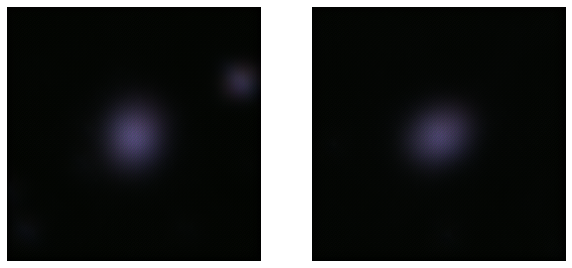

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  77  d1_loss ::: 0.23335960805416106  d2_loss :::0.19639328539378711
genLoss ::: 26.895853527386983  vggLoss ::: 0.015441405524810155  MeanLoss  ::: 0.00027909375979409863


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  78  d1_loss ::: 0.2148759504813097  d2_loss :::0.22642857685685172
genLoss ::: 26.407937542597452  vggLoss ::: 0.015420473568762342  MeanLoss  ::: 0.0002779902206384577


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  79  d1_loss ::: 0.20101371680696806  d2_loss :::0.2010140481476393
genLoss ::: 26.476760896046958  vggLoss ::: 0.01540253587688009  MeanLoss  ::: 0.0002763530164277957


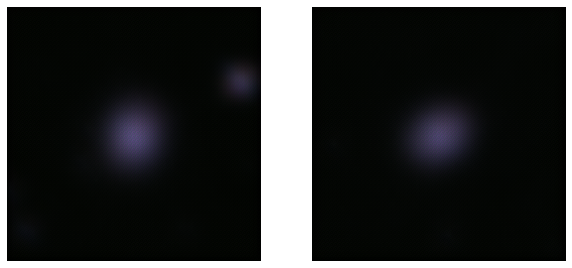

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  80  d1_loss ::: 0.21487638428807282  d2_loss :::0.19870235443119044
genLoss ::: 24.81633014678955  vggLoss ::: 0.015386844690268239  MeanLoss  ::: 0.00027634861495850295


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  81  d1_loss ::: 0.20101429508358706  d2_loss :::0.20794527459432857
genLoss ::: 24.583599233627318  vggLoss ::: 0.015373289476459225  MeanLoss  ::: 0.0002751279576235296


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  82  d1_loss ::: 0.2102579168975353  d2_loss :::0.20794448763135767
genLoss ::: 23.30639408826828  vggLoss ::: 0.015358437411487102  MeanLoss  ::: 0.0002734186173862933


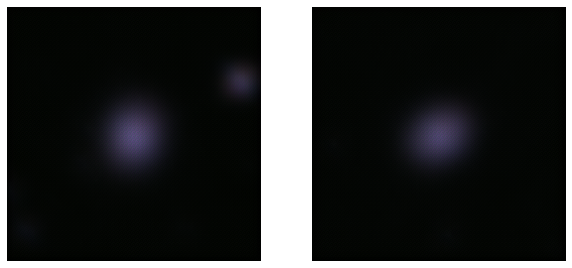

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  83  d1_loss ::: 0.219500350356102  d2_loss :::0.23335991074646714
genLoss ::: 22.4218367656072  vggLoss ::: 0.015337007973964015  MeanLoss  ::: 0.0002722157085372601


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  84  d1_loss ::: 0.22876749649643904  d2_loss :::0.1848429387311166
genLoss ::: 24.66758149464925  vggLoss ::: 0.015315578738227486  MeanLoss  ::: 0.00027236624834282944


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  85  d1_loss ::: 0.1963919096690006  d2_loss :::0.1848406241342573
genLoss ::: 25.020501641432443  vggLoss ::: 0.015298309472079078  MeanLoss  ::: 0.0002712708856658234


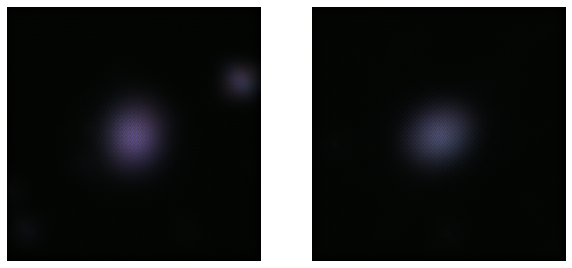

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  86  d1_loss ::: 0.1940817080588627  d2_loss :::0.1987031365933815
genLoss ::: 25.193786406517027  vggLoss ::: 0.015275662935649355  MeanLoss  ::: 0.00027083971775330914


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  87  d1_loss ::: 0.2079458211385917  d2_loss :::0.2194973283013008
genLoss ::: 23.30070219039917  vggLoss ::: 0.015255882296090324  MeanLoss  ::: 0.00026941642063320613


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  88  d1_loss ::: 0.21720306119588126  d2_loss :::0.18946082179750973
genLoss ::: 22.199957474072775  vggLoss ::: 0.015236760986347993  MeanLoss  ::: 0.00026866664508512863


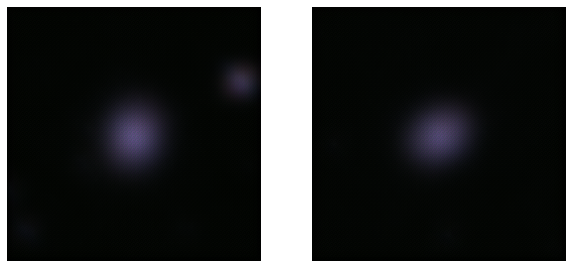

100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  89  d1_loss ::: 0.19177199786368482  d2_loss :::0.22412116030852
genLoss ::: 24.27248320579529  vggLoss ::: 0.015217884195347626  MeanLoss  ::: 0.0002667013330210466


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  90  d1_loss ::: 0.16866643438766585  d2_loss :::0.2125657927018655
genLoss ::: 25.52545274098714  vggLoss ::: 0.015202392280722657  MeanLoss  ::: 0.00026630256470525635


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  91  d1_loss ::: 0.19870550750123964  d2_loss :::0.22873962720243518
genLoss ::: 23.045237708091737  vggLoss ::: 0.01518638238000373  MeanLoss  ::: 0.00026617308976710773


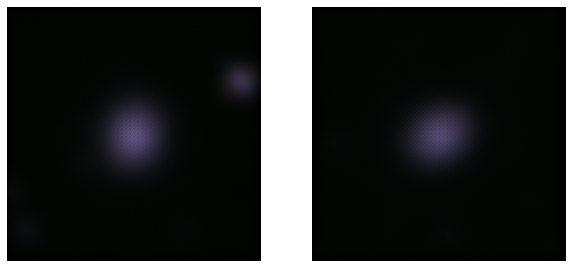

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  92  d1_loss ::: 0.21949778844916482  d2_loss :::0.18252943540624264
genLoss ::: 21.793992408116658  vggLoss ::: 0.015171851217746734  MeanLoss  ::: 0.0002664491303827769


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  93  d1_loss ::: 0.2495416171352831  d2_loss :::0.18715155886275833
genLoss ::: 20.302125509579977  vggLoss ::: 0.01516444186369578  MeanLoss  ::: 0.0002664504228353811


100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch ::::  94  d1_loss ::: 0.8919029998726062  d2_loss :::0.27015104515399646
genLoss ::: 21.269006939729056  vggLoss ::: 0.015152894364049038  MeanLoss  ::: 0.00026438488105971677


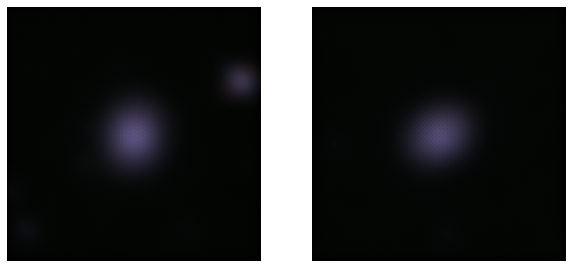

100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  95  d1_loss ::: 1.006741414081771  d2_loss :::0.2834394293401663
genLoss ::: 27.394434322913487  vggLoss ::: 0.015147113023946683  MeanLoss  ::: 0.000265183061856078


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  96  d1_loss ::: 0.5779724576104702  d2_loss :::0.1919235779861457
genLoss ::: 31.270046122868855  vggLoss ::: 0.015153533794606726  MeanLoss  ::: 0.00026661636923866656


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  97  d1_loss ::: 2.2909074168012014  d2_loss :::0.2294868617489101
genLoss ::: 43.758345580101015  vggLoss ::: 0.0151339589462926  MeanLoss  ::: 0.00026542120564651366


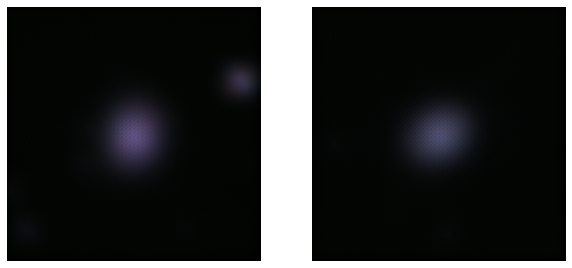

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  98  d1_loss ::: 0.9322955467458731  d2_loss :::0.5613794247309367
genLoss ::: 45.2458304087321  vggLoss ::: 0.015127084280053774  MeanLoss  ::: 0.00026646240973301853


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  99  d1_loss ::: 0.20802206735543408  d2_loss :::0.19408121109008789
genLoss ::: 44.90057168006897  vggLoss ::: 0.01510081454180181  MeanLoss  ::: 0.00026377039296979394


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  100  d1_loss ::: 0.8378173906868331  d2_loss :::0.22379261255264282
genLoss ::: 48.94336357116699  vggLoss ::: 0.015065101829047004  MeanLoss  ::: 0.0002645633721840568


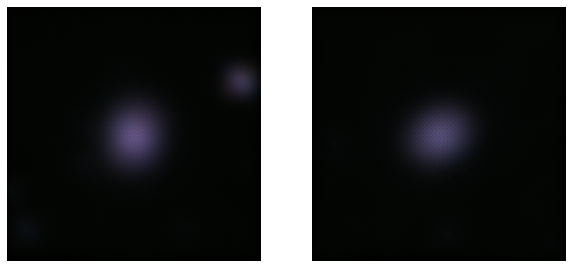

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  101  d1_loss ::: 0.25419165362914403  d2_loss :::0.21949660778045654
genLoss ::: 50.85547582308451  vggLoss ::: 0.01503469650633633  MeanLoss  ::: 0.00026112681225640697


100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


Epoch ::::  102  d1_loss ::: 0.5620926981170972  d2_loss :::0.5869969129562378
genLoss ::: 53.87956930796305  vggLoss ::: 0.015022998753314218  MeanLoss  ::: 0.00025991358367415763


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  103  d1_loss ::: 0.6643301629399261  d2_loss :::0.426066725254059
genLoss ::: 51.6769502957662  vggLoss ::: 0.015009977777178088  MeanLoss  ::: 0.00025980649782771553


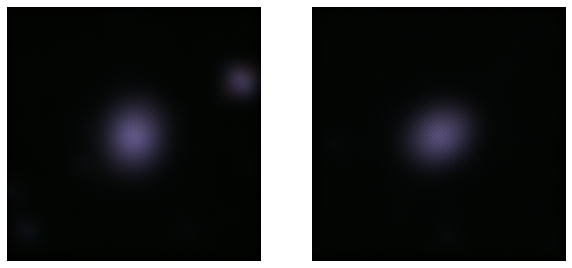

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  104  d1_loss ::: 0.27910825063784916  d2_loss :::0.5568390068908532
genLoss ::: 54.2213490486145  vggLoss ::: 0.014998122196023663  MeanLoss  ::: 0.00025942244052809353


100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch ::::  105  d1_loss ::: 0.2835129905333969  d2_loss :::0.27926832834879556
genLoss ::: 41.38322622378667  vggLoss ::: 0.014982436892266075  MeanLoss  ::: 0.0002593241668364499


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  106  d1_loss ::: 0.17559853050285615  d2_loss :::0.19177072048187255
genLoss ::: 55.53946188290914  vggLoss ::: 0.01496951598674059  MeanLoss  ::: 0.00025674078109053273


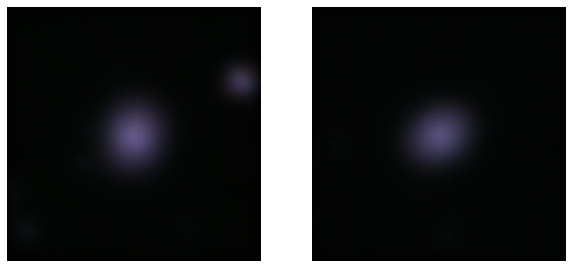

100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  107  d1_loss ::: 0.21256717820962384  d2_loss :::0.17790777683258058
genLoss ::: 52.12103435198466  vggLoss ::: 0.014975111683209736  MeanLoss  ::: 0.00025823881126901447


100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch ::::  108  d1_loss ::: 0.21025464807947478  d2_loss :::0.19177072048187255
genLoss ::: 52.999643150965376  vggLoss ::: 0.014960998094951113  MeanLoss  ::: 0.00025806733247009107


 90%|█████████ | 54/60 [00:32<00:03,  1.65it/s]

In [ ]:
batch_count=60
import torch
torch.cuda.empty_cache()
for epoch in range(epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]
     

    
    for batch in tqdm(range(batch_count)):
        hr_imagesList = [img for img in HR_images_list[batch*batch_size:(batch+1)*batch_size]]
        lr_images = loadLRImages(hr_imagesList,hr_path)/255
        hr_images = loadImages(hr_imagesList,hr_path,True)/255
        
                
        disc.zero_grad()

        gen_out = gen(torch.from_numpy(lr_images).to(cuda).float())
        _,f_label = disc(gen_out)
        _,r_label = disc(torch.from_numpy(hr_images).to(cuda).float())
        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        # d_loss = d1_loss+d2_loss
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        # print(d1_loss,d2_loss)
#         d_loss.backward(retain_graph=True)
        disc_optimizer.step()
        

        gen.zero_grad()      
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](torch.from_numpy(hr_images).to(cuda).float()))
        m_loss = mse_loss(gen_out,torch.from_numpy(hr_images).to(cuda).float())
        
        generator_loss = g_loss + v_loss + m_loss
        # v_loss.backward(retain_graph=True)
        # m_loss.backward(retain_graph=True)
        # g_loss.backward()
        # print(generator_loss)

        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())

        
        
#         print("d1Loss ::: "+str((d1_loss.item()))+" d2Loss ::: "+str((d2_loss.item())))
#         print("gloss ::: "+str((g_loss.item()))+" vloss ::: "+str((v_loss.item()))+" mloss ::: "+str((m_loss.item())))
    print("Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list))+"  d2_loss :::"+str(np.mean(d2loss_list)))
    print("genLoss ::: "+str(np.mean(gloss_list))+"  vggLoss ::: "+str(np.mean(vloss_list))+"  MeanLoss  ::: "+str(np.mean(mloss_list)))
    
    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()
        
        out_images = imagePostProcess(IMAGES[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
#         print(out_images.shape)
#         test_images = loadLRImages(images[:-3],hr_path)/255
#         test_images = np.reshape(test_images,(test_images[0],test_images.shape[3],test_images.shape[1],test_images.shape[2]))
#         out_images = gen(torch.from_numpy(test_images).to(cuda).float())
#         out_images = np.reshape(out_images,(out_images[0],out_images[2],out_images[3],out_images[1]))
        show_samples(out_images)
        